
[![AnalyticsDojo](https://github.com/rpi-techfundamentals/spring2019-materials/blob/master/fig/final-logo.png?raw=1)](http://rpi.analyticsdojo.com)
<center><h1>Titanic PCA</h1></center>
<center><h3><a href = 'http://introml.analyticsdojo.com'>introml.analyticsdojo.com</a></h3></center>



# Titanic Classification - Titanic Visualize Decision Tree

As an example of how to work with both categorical and numerical data, we will perform survival predicition for the passengers of the HMS Titanic.


In [2]:
import os
import pandas as pd
train = pd.read_csv('https://raw.githubusercontent.com/rpi-techfundamentals/spring2019-materials/master/input/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/rpi-techfundamentals/spring2019-materials/master/input/test.csv')

print(train.columns, test.columns)

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object') Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


Here is a broad description of the keys and what they mean:

```
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
survival        Survival
                (0 = No; 1 = Yes)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)
boat            Lifeboat
body            Body Identification Number
home.dest       Home/Destination
```

In general, it looks like `name`, `sex`, `cabin`, `embarked`, `boat`, `body`, and `homedest` may be candidates for categorical features, while the rest appear to be numerical features. We can also look at the first couple of rows in the dataset to get a better understanding:

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### Preprocessing function

We want to create a preprocessing function that can address transformation of our train and test set.  

In [4]:
from sklearn.impute import SimpleImputer
import numpy as np

cat_features = ['Pclass', 'Sex', 'Embarked']
num_features =  [ 'Age', 'SibSp', 'Parch', 'Fare'  ]


def preprocess(df, num_features, cat_features, dv):
    features = cat_features + num_features
    if dv in df.columns:
      y = df[dv]
    else:
      y=None 
    #Address missing variables
    print("Total missing values before processing:", df[features].isna().sum().sum() )
  
    imp_mode = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    df[cat_features]=imp_mode.fit_transform(df[cat_features] )
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    df[num_features]=imp_mean.fit_transform(df[num_features])
    print("Total missing values after processing:", df[features].isna().sum().sum() )
   
    X = pd.get_dummies(df[features], columns=cat_features, drop_first=True)
    return y,X

y, X =  preprocess(train, num_features, cat_features, 'Survived')
test_y, test_X = preprocess(test, num_features, cat_features, 'Survived')

Total missing values before processing: 179
Total missing values after processing: 0
Total missing values before processing: 87
Total missing values after processing: 0


# PCA Analysis

See [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). 

You can incorporate PCA based on number of components or the variance explained. 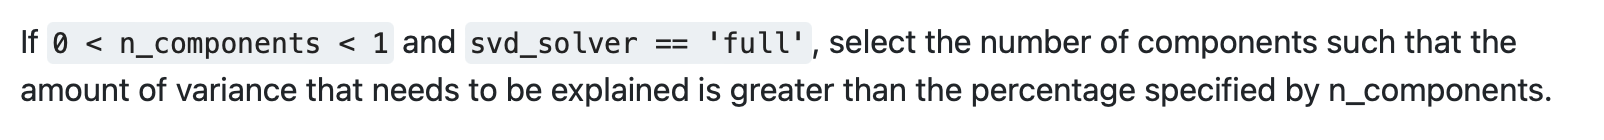

In [5]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
pca.fit(X)
X2=pca.transform(X)

In [6]:
#This indicates the amount of variance explained by each of the principal components.
print(pca.explained_variance_)

[2.47107661e+03 1.67651481e+02 1.25165106e+00 4.73653673e-01
 3.18808533e-01]


In [7]:
from sklearn.decomposition import PCA
pca2 = PCA(n_components=0.97)
pca2.fit(X)
X3=pca2.transform(X)

In [8]:
print(pca2.explained_variance_)

[2471.07660618  167.65148116]


In [9]:
cov_data = np.corrcoef(X3.T)
cov_data

array([[1.00000000e+00, 1.90521771e-16],
       [1.90521771e-16, 1.00000000e+00]])

### Elbow Plot and Kaisers Rule Cutoff

[Here](https://docs.displayr.com/wiki/Kaiser_Rule) is a link to documentation of Kaisers Rule. 


Data passed Bartlett’s test for sphericity.
Performing PCA  using rotation: quartimax  factors:  4 and standardization:  False


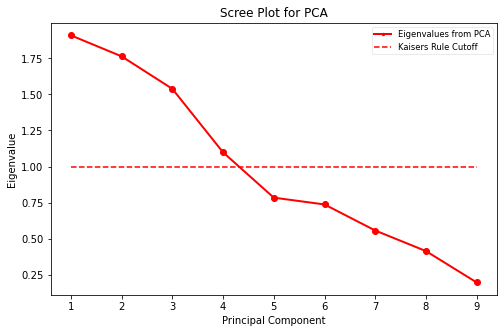

In [21]:
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib
def scree_plot(eigvals):
    fig = plt.figure(figsize=(8,5))
    sing_vals = np.arange(len(eigvals)) + 1
    plt.plot(sing_vals, eigvals, 'ro-', linewidth=2)
    #####horizontal line
    horiz_line_data = np.array([1 for i in range(len(sing_vals))])
    plt.plot(sing_vals, horiz_line_data, 'r--')
    plt.title('Scree Plot for PCA')
    plt.xlabel('Principal Component')
    plt.ylabel('Eigenvalue')
    #I don't like the default legend so I typically make mine like below, e.g.
    #with smaller fonts and a bit transparent so I do not cover up data, and make
    #it moveable by the viewer in case upper-right is a bad place for it
    leg = plt.legend(['Eigenvalues from PCA', 'Kaisers Rule Cutoff'], loc='best', borderpad=0.3,
                     shadow=False, prop=matplotlib.font_manager.FontProperties(size='small'),
                     markerscale=0.4)
    leg.get_frame().set_alpha(0.4)

    #plt.savefig(os.path.join(save_dir / (name +'.jpg')))
    return plt

def pca_workflow(X, factors=-1, standardize=False, rotation='quartimax'):
    """
    This will perform factor analysis, calculating the number of factors.
    Printing scree plots, etc.
    """

    chi_square_value,p_value=calculate_bartlett_sphericity(X)

    if round(p_value,2)<=0.05:
        print("Data passed Bartlett’s test for sphericity.")
    else:
        print("Data failed Bartlett’s test for sphericity, use PCA with caution.")
    
    #This is used to calculate
    if factors ==-1:
        fa = FactorAnalyzer(n_factors=X.shape[1], rotation=None, method='ml')
        fa.fit_transform(X)
        # Check Eigenvalues
        ev, v = fa.get_eigenvalues()
        #set the number of factors as where Eigenvalue > 1.0
        factors = np.sum(ev>1.0)
    print ("Performing PCA  using rotation:", rotation, " factors: ", factors, "and standardization: ", standardize)
    loading_cols=['F'+str(x+1) for x in range(factors)]
    plot=scree_plot(ev)

    if standardize:
        X = StandardScaler().fit_transform(X)

    fa = FactorAnalyzer(n_factors=factors, method='principal', rotation=rotation)
    fa.fit(X)

    #Change it back to a dataframe.
    results=pd.DataFrame(fa.transform(X),columns=loading_cols)
    
    return results

X4= pca_workflow(X)

,Age,SibSp,Parch,Fare,Pclass_2,Pclass_3,Sex_male,Embarked_Q,Embarked_S,F1,F2,F3,F4
Age,1.000000,-0.232625,-0.179191,0.091566,0.006589,-0.281004,0.084153,-0.013855,-0.019336,-5.866885e-01,3.811172e-02,-3.979659e-02,4.697929e-01
SibSp,-0.232625,1.000000,0.414838,0.159651,-0.055932,0.092548,-0.114631,-0.026354,0.068734,7.266238e-01,1.159037e-01,1.523544e-01,9.665757e-02
Parch,-0.179191,0.414838,1.000000,0.216225,-0.000734,0.015790,-0.245489,-0.081228,0.060814,7.530177e-01,9.012244e-02,1.703344e-02,2.089974e-01
Fare,0.091566,0.159651,0.216225,1.000000,-0.118557,-0.413333,-0.182333,-0.117216,-0.162184,1.894779e-01,-3.740721e-02,1.871599e-02,8.756367e-01
Pclass_2,0.006589,-0.055932,-0.000734,-0.118557,1.000000,-0.565210,-0.064746,-0.127301,0.189980,4.552872e-04,1.211537e-01,-9.175741e-01,-1.588046e-01
Pclass_3,-0.281004,0.092548,0.015790,-0.413333,-0.565210,1.000000,0.137143,0.237449,-0.015104,1.356613e-01,-8.931807e-02,7.454824e-01,-5.398062e-01
Sex_male,0.084153,-0.114631,-0.245489,-0.182333,-0.064746,0.137143,1.000000,-0.074115,0.119224,-4.686491e-01,3.593321e-01,3.241968e-01,-1.889437e-01
Embarked_Q,-0.013855,-0.026354,-0.081228,-0.117216,-0.127301,0.237449,-0.074115,1.000000,-0.499421,-3.289038e-02,-8.285253e-01,1.156588e-01,-2.081933e-01
Embarked_S,-0.019336,0.068734,0.060814,-0.162184,0.189980,-0.015104,0.119224,-0.499421,1.000000,6.820785e-02,8.340531e-01,-1.170429e-01,-2.047724e-01
F1,-0.586688,0.726624,0.753018,0.189478,0.000455,0.135661,-0.468649,-0.032890,0.068208,1.000000e+00,-8.423241e-16,-1.197446e-16,4.285137e-16


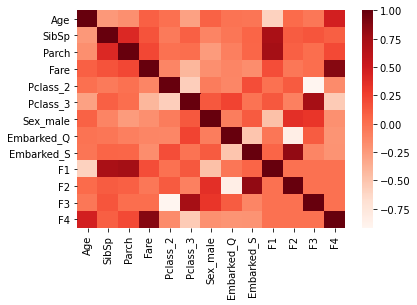

In [26]:
X4ALL = pd.concat([X,X4], axis =1) 

import seaborn as sb
corr = X4ALL.corr()
sb.heatmap(corr, cmap="Reds")
corr

### Train Test Split

Now we are ready to model. We are going to separate our Kaggle given data into a "Train" and a "Validation" set. 



In [9]:
#Import Module
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=122,stratify=y)

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn import metrics

In [11]:
from sklearn import tree
classifier = tree.DecisionTreeClassifier(max_depth=3)
#This fits the model object to the data.
classifier.fit(train_X[['Age','Sex_male']], train_y)
#This creates the prediction. 
train_y_pred = classifier.predict(train_X[['Age','Sex_male']])
val_y_pred = classifier.predict(val_X[['Age','Sex_male']])
test['Survived'] = classifier.predict(test_X[['Age','Sex_male']])
print("Metrics score train: ", metrics.accuracy_score(train_y, train_y_pred) )
print("Metrics score validation: ", metrics.accuracy_score(val_y, val_y_pred) )

Metrics score train:  0.7929373996789727
Metrics score validation:  0.8134328358208955
